# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>

# Devoir 3 - Régression logistique ( 15 points )

Le présent devoir concerne les notions de la régression linéaire vues au Chapitre 2 du cours. Pour ce devoir, vous devez élaborer une analyse complète de régression à l'exercice 1 pour répondre aux questions de l'exercice 2.


## Devoir effectué par

NOM, PRÉNOM - MATRICULE

NOM, PRÉNOM - MARTICULE

**Déclaration d’intégrité relative au plagiat**

Nous certifions sur l’honneur :
- Que les résultats décrits dans ce rapport sont l’aboutissement de notre travail.
- Que nous sommes les auteurs de ce rapport.
- Que nous n'avons pas utilisé des sources ou résultats tiers sans clairement les citer et les référencer selon les règles bibliographiques préconisées.

Nous déclarons que ce travail ne peut être soupçonné de plagiat.


# Contexte : Débordements d'égoûts

Ce devoir est directement dérivé de l'un de mes projets de recherche. 

Les débordements des réseaux d’égouts constituent une menace environnementales et une menace pour la santé publique. Les débordements, également appelés *surverses*, se produisent lorsque l’intensité des précipitations excède la capacité de transport du réseau. Le mélange des eaux usées et des eaux pluviales est alors directement déversé dans le milieu récepteur sans passer par la station d'épuration. Dans ce devoir, on s'intéresse aux surverses d'un ouvrage de débordement du réseau de la Ville de Montréal en fonction des précipitations enregistrées à une station à proximité.

Le jeu de données *surverse_data.csv* contient les informations suivantes sur les surverses pour les mois de mai à octobre inclusivement :

- Date : la date ;
- Surverse : 1 s'il y a eu débordement dans la journée, 0 sinon ;
- d15min : la quantité maximale de précipitations (en *mm*) tombée en 15 min durant la journée ;
- d30min : la quantité maximale de précipitations (en *mm*) tombée en 30 min durant la journée ;
- ...

Le but général consiste à trouver la meilleure régle de prédiction des surverses en fonction des précipitations. Voici quelques exemples de règles :

- Règle 1 : On prédit une surverse s'il pleut plus que 5 *mm* en 15 min.
- Règle 2 : On prédit une surverse s'il pleut plus que 4 *mm* en 15 min et plus de 10 *mm* en 1h.

À partir des données, il faudra que vous identifier les meilleures règles de prédiction.


# Consignes

- Le devoir doit être remis sur Moodle **avant 23h59 le mardi 6 octobre 2020.** Les retards ne seront pas tolérés car le solutionnaire sera publié dès mercredi.
- Le devoir a une pondération de 7.5%.
- Écrivez vos noms et vos matricules dans l'espace prévu à cet effet de cette cellule.
- Vous pouvez compléter le devoir en équipe de deux personnes. Dans ce cas, un seul fichier par équipe doit être remis. Pour vous aider à trouver un coéquipier, le canal de discussion *#trouver_un_coéquipier* a été créé sur Slack.
- Le devoir doit être complété dans le présent calepin Jupyter en ajoutant autant de cellules de texte et de code que nécessaires. Vous remettrez ce fichier en format *.ipynb*. Le nom du fichier doit être *matricule1_matricule2_devoir3.ipynb*.
- N'utilisez que les librairies introduites à la cellule suivante.
- Vous pouvez utiliser directement les fonction `auc()` et `rocplot()` fournies. 

## Chargement des libairies

In [1]:
using CSV
using Combinatorics
using DataFrames
using Dates
using GLM
using Gadfly
using MLBase
using Statistics

In [2]:
"""
    auc(gt::Array{<:Real}, scores::Array{<:Real})

Compute the area under the ROC curve based on the ground truth `gt` and the success probability `scores`.

See also `roc()` of MLBase. 
"""
function auc(gt::Array{<:Real},scores::Array{<:Real})
   
    # Compute the ROC curve for 100 equally spaced thresholds - see `roc()` 
    r = roc(gt, scores)
    
    # Compute the true positive rate and false positive rate
    tpr = true_positive_rate.(r)
    fpr = false_positive_rate.(r)
    
    # Numerical computation of the area under the ROC curve
    p = sortperm(fpr)
    
    permute!(tpr,p)
    permute!(fpr,p)
    
    area = 0.0
    
    for i in 2:length(tpr)
        dx = fpr[i] - fpr[i-1]
        dy = tpr[i] - tpr[i-1]
        area += dx*tpr[i-1] + dx*dy/2
    end
    
    return area
    
end


"""
    rocplot(gt::Array{<:Real},scores::Array{<:Real})

Show the ROC curve corresponding to the ground truth `gt` and the success probability `scores`.

The curve is computed for 100 equally spaced thresholds.
"""
function rocplot(gt::Array{<:Real},scores::Array{<:Real})
    
    # Compute the ROC curve for 100 equally spaced thresholds - see `roc()` 
    r = roc(gt, scores)
    
    # Compute the true positive rate and false positive rate
    tpr = true_positive_rate.(r)
    fpr = false_positive_rate.(r)
    
    return plot(x=fpr, y=tpr, Geom.line, Geom.abline(color="red", style=:dash),
        Guide.xlabel("False Positive Rate"), Guide.ylabel("True Positive Rate"))
    
end

rocplot

# Chargement des données

In [3]:
data = CSV.read("surverse_data.csv")
first(data, 10)

,Date,Surverse,d15min,d30min,d1h,d2h,d4h,d6h,d12h
,Date,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2013-05-01,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-05-02,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-05-03,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-05-04,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2013-05-05,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2013-05-06,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2013-05-07,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2013-05-08,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2013-05-09,0,0.25,0.25,0.25,0.5,0.5,0.5,0.5


## Filtrage des données

Il y a beaucoup plus de jours où il n'y a pas de surverse et où il ne pleut pas. Pour réduire le débalancement des classes et le nombre de données, les journées où il ne pleut pas sont retirées.

**Note :**
C'est un choix que j'ai décidé de faire pour ce devoir. Vous n'êtes pas obligé de faire la même chose !

In [4]:
filter!(row -> row.d15min>0, data)
first(data, 10)

,Date,Surverse,d15min,d30min,d1h,d2h,d4h,d6h,d12h
,Date,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2013-05-09,0,0.25,0.25,0.25,0.5,0.5,0.5,0.5
2,2013-05-10,0,0.25,0.25,0.25,0.25,0.25,0.25,0.25
3,2013-05-11,1,1.5,2.75,4.5,7.25,10.5,11.25,12.25
4,2013-05-13,0,0.25,0.25,0.25,0.25,0.25,0.5,0.5
5,2013-05-15,0,1.25,1.75,2.25,3.75,4.25,4.25,4.25
6,2013-05-19,0,0.25,0.5,0.5,0.5,1.0,1.0,1.0
7,2013-05-20,0,2.0,2.75,4.0,5.0,5.5,5.5,6.25
8,2013-05-21,0,1.5,1.75,2.25,2.75,3.25,3.25,3.25
9,2013-05-22,0,0.25,0.25,0.5,0.5,1.0,1.75,1.75


## Partitionnement du jeu de données

Le jeu de données est partionné en deux ensembles :
- l'ensemble d'entraînement composé des année 2013 à 2018 ;
- l'ensemble de validation composé de l'année 2019.

Les données de l'ensemble de validation ne seront pas utilisées pour estimer les paramètres du modèle de régression logistique. Elle seront utilisées pour comparer le pouvoir prédictif des modèles.

In [5]:
train = filter(row -> year(row.Date)<2019, data)
valid = filter(row -> year(row.Date)==2019, data)

println("L'échantillon d'entraînement contient ", sum(train.Surverse), " surverses sur ", length(train.Surverse),
    " jours.")

println("L'échantillon de validation contient ", sum(valid.Surverse), " surverses sur ", length(valid.Surverse),
    " jours.")

L'échantillon d'entraînement contient 95 surverses sur 437 jours.
L'échantillon de validation contient 10 surverses sur 73 jours.


## Analyse exploratoire sommaire

Je trace ici les surverses en fonction des cumuls de précipitations durant 1h en guise d'analyse exploratoire sommaire. Je vous encorage à poursuivre l'anlyse exploratoire pour mieux cerner le problème. 

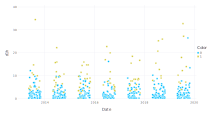

In [6]:
Gadfly.set_default_plot_size(21cm, 12cm)
plot(data, x=:Date, y=:d1h, color=string.(data.Surverse), Geom.point,
    Coord.cartesian(xmin=Date(2012,12,31)))

# Exercice 1 - Cumul des précipitations sur 1h

## a) Estimation des paramètres

En utilisant comme seule variable explicative le cumul de précipitation sur 1h, estimez les paramètres avec les données de l'ensemble d'entraînement du modèle de régression logistique en utilisant le fonction de lien logit. Donnez explicitement β̂₀ et β̂₁.

**Suggestion :** Utilisez la fonction `glm()` de la librairie *GLM.jl*.

In [7]:
model = glm(@formula(Surverse ~ d1h), train, Binomial(), LogitLink())
β̂ = coef(model)

2-element Array{Float64,1}:
 -3.354622611181047
  0.451395377950576

## b) S'il tombe 5 mm de pluie en une heure, quelle est la probabilité qu'il y ait surverse ?

In [8]:
# La probabilité de succès est estimée par la fonction de lien logit évaluée au point [1, 5] avec les paramètres β̂
x₀ = [1, 5]
p = exp(x₀'*β̂) / (1 + exp(x₀'*β̂))

0.2501812751470308

## c) Quelle est la quantité de pluie pour laquelle la probabilité de surverse est égale à 95% ?
Expliquez bien les détails de votre calcul.

In [9]:
# On doit inverser la fonction de lien logit
x = (log(.95/.05) - β̂[1])/β̂[2]

13.954643529906019

## d) Évaluation de la qualité du modèle

Tracez la courbe ROC du modèle et calculez l'aire sous la courbe. Donnez une interprétation pratique de ces mesures.

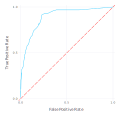

In [10]:
scores = predict(model)
Gadfly.set_default_plot_size(12cm, 12cm)
rocplot(train.Surverse, scores)

In [11]:
# Aire sous la courbe ROC
auc(train.Surverse, scores)

0.8928747306863651

## e) Règle de décision

Laquelle des règles suivantes est la plus appropriée pour prédire l'occurrence d'une surverse :

- Règle 1 : si les précipitations accumulées en 1h dépassent 3.4 *mm*.
- Règle 2 : si les précipitations accumulées en 1h dépassent 5.9 *mm*.
- Règle 3 : si les précipitations accumulées en 1h dépassent 7.4 *mm*.
- Règle 4 : si les précipitations accumulées en 1h dépassent 9.0 *mm*.

Justifiez bien quantitativement votre réponse. Utilisez les mesures de qualité qui vous semblent les plus appropriées.

In [12]:
seuils = [3.4, 5.9, 7.4, 9.0]

for s in seuils

    r = roc(train.Surverse, train.d1h.>s)
    println("Pour le seuil ", s, " mm :")
    println("\t","La sensibilité est égale à ", recall(r))
    println("\t","La précision est égale à ", precision(r))
    println("\t","Le score F1 est égal à ", f1score(r))
    
end

Pour le seuil 3.4 mm :
	La sensibilité est égale à 0.9157894736842105
	La précision est égale à 0.5240963855421686
	Le score F1 est égal à 0.6666666666666666
Pour le seuil 5.9 mm :
	La sensibilité est égale à 0.6421052631578947
	La précision est égale à 0.6559139784946236
	Le score F1 est égal à 0.648936170212766
Pour le seuil 7.4 mm :
	La sensibilité est égale à 0.5263157894736842
	La précision est égale à 0.7246376811594203
	Le score F1 est égal à 0.6097560975609756
Pour le seuil 9.0 mm :
	La sensibilité est égale à 0.3473684210526316
	La précision est égale à 0.7857142857142857
	Le score F1 est égal à 0.48175182481751827


Il n'y a pas une seule réponse possible. La règle 1 maximise à fois la sensibilité et le score F1 tandis que la règle 4 maximise la précision. Je choisirais la régle 1 qui maximise le score F1 car cette mesure est un bon compromis entre précision et sensibilité.

## f) Justification de la méthodologie

Un ingénieur de la Ville vous regarde incrédule faire la présentation de votre modèle et vous demande à quoi ça sert de faire aussi compliqué. D'après lui, après avoir vu le graphique présenté à l'analyse exploratoire, il est en mesure d'estimer un seuil de surverse. À l'oeil, il estime le seuil à 4 *mm*. Comment pouvez justifier l'utilisation de votre approche ? 

**Note :** C'est une question typique que vous vous ferez certainement poser !

Bien qu'il soit possible dans le cas unidimensionnel de définir un visuellement seuil, cette méthode est sujette à des erreurs d'interprétation, d'échelle et de lecture des graphiques. La régression logistique, quant à elle, trouve le seuil qui maximise le critère choisi, sans subjectivité, et de façon totalement automatique. Pas besoin de regarder toutes les stations pour estimer le seuil des autres stations. Les graphiques peuvent servir à valider les résultats obtenus.

Par ailleurs, il devriendra impossible de déterminer visuellement le seuil lorsque plus de 2 variables explicatives sera utilisées. Ce n'est pas un problème avec la régression logistique.

# Exercice 2 - Prédiction des surverses

Identifiez les variables permettant de mieux prédire les surverses. Vous devez obligatoirement utilisée la régression logistique mais les détails de la méthodologie sont laissés à votre discrétion. Vous pouvez utiliser comme bon vous semble la courbe ROC, l'échantillon d'entraînement, etc.

**Note :** Vous ne devez ici qu'identifier les variables explicatives les plus importantes pour la prédiction des surverses, par exemple le cumul des précipitations en 15 min et 30 min. Vous ne devez pas spécifier la règle de décision optimale.


Dans mon cas, j'ai décidé d'estimer les paramètres sur l'échantillon d'entraînement et de calculer la courbe ROC pour les prédictions obtenus avec l'échantillon de validation pour tous les modèles. J'ai choisi le modèle qui maximise l'aire sous la courbe ROC de l'échantillon de validation. Il y a 255 modèles possibles et les parcourir un à un peut être long. C'est pourquoi une procédure itérative telle que la régression pas-à-pas pourrait aussi être mise en oeuvre.

En parcourant tous les modèles, le meilleur modèle est celui qui utilise les cumuls de précipitations sur 15 min et 1 h.

Il y a bien sûr d'autres approches possibles et nous corrigerons en conséquences.

In [13]:
res = DataFrame(Variable = Array{String}[], AUC = Float64[])

varnames = Symbol.(names(train)[3:end])

for v in combinations(varnames)
    model = glm(Term(:Surverse) ~ sum(Term.(v)),train, Binomial(), LogitLink())
    scores = predict(model, valid)
    scores = convert(Array{Float64}, scores) # Je ne sais pas pourquoi GLM renvoie des Missings !
    area = auc(valid.Surverse, scores)
    push!(res, [String.(v), area])
end
sort!(res, :AUC, rev=true)

,Variable,AUC
,Array…,Float64
1,"[""d15min"", ""d1h""]",0.957937
2,"[""d15min"", ""d30min"", ""d1h""]",0.957937
3,"[""d30min"", ""d1h""]",0.955556
4,"[""d1h""]",0.953968
5,"[""d15min"", ""d2h""]",0.952381
6,"[""d30min"", ""d2h""]",0.952381
7,"[""d2h""]",0.951587
8,"[""d1h"", ""d2h""]",0.950794
9,"[""d15min"", ""d30min"", ""d2h""]",0.950794
